<h1>Project 3</h1>

<h3>Run this is Sagemaker Notebook</h3>
<h3>Install and import</h3>

In [1]:
!pip install smdebug;
! pip install -U smdebug;
! pip install protobuf==3.20.*


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6295 sha256=da362263433d9415911436ad39b81046792d97bc38dcca4861c22415cc6c2474
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4


In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker_session = sagemaker.Session()

my_session = boto3.session.Session()
region = my_session.region_name
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/project3"

role = sagemaker.get_execution_role()
region

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


'us-east-1'

<h3>Retrieve the data and copy it to S3</h3>

In [ ]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
#!aws s3 cp dogImages s3://udacitysolution/ --recursive

In [ ]:
# Upload files to s3
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

In [1]:
import boto3
import sagemaker
import boto3
import pandas as pd
import os

bucket = "sagemaker-us-east-1-053987932055" 
prefix = "sagemaker/project3"
s3 = boto3.client('s3')
testlist = []
trainlist = []
validlist = []
r = [(testlist,'test'), (trainlist,'train'), (validlist,'valid')]

for i in r:
   
    result = s3.list_objects_v2(Bucket=bucket, Prefix='sagemaker/project3/{}/'.format(i[1]),    Delimiter='/')
    for obj in result.get('CommonPrefixes'):

        i[0].append(obj.get('Prefix').split('.')[1].split('/')[0])                            
    print('number of classes for {} is {}'.format(i[1],len(i[0])))   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
number of classes for test is 133
number of classes for train is 133
number of classes for valid is 133


In [18]:

# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": CategoricalParameter([3, 5, 10, 20])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [28]:
# Create estimators for the HPs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo1.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge" #"ml.g4dn.2xlarge"  # GPU
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [16]:


train_path= "s3://{}/{}/{}/".format(bucket, prefix, 'train')
valid_path= "s3://{}/{}/{}/".format(bucket, prefix, 'valid')
test_path= "s3://{}/{}/{}/".format(bucket, prefix, 'test')

s3_output_dir = "s3://{}/{}/".format(bucket, prefix)
s3_model_dir = "s3://{}/{}/".format(bucket, "project_image_classification/model")

os.environ['SM_CHANNEL_TRAIN']=train_path
os.environ['SM_CHANNEL_VAL']=valid_path
os.environ['SM_CHANNEL_TEST']=test_path
os.environ['SM_MODEL_DIR']=s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir

In [30]:
tuner.fit({"train": train_path, "val": valid_path, "test": test_path})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.....................................................................................................................................................................................................................................................................................................!


In [32]:
import pandas as pd

hpytuner = sagemaker.HyperparameterTuningJobAnalytics('pytorch-training-231016-1612')

full_df = hpytuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue")
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Number of training jobs with valid objective: 2
{'lowest': 0.033799998462200165, 'highest': 0.050200000405311584}


,batch-size,epochs,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""32""","""3""",0.004563,pytorch-training-231016-1612-001-e090c177,Completed,0.0338,2023-10-16 16:15:14+00:00,2023-10-16 16:26:16+00:00,662.0
0,"""128""","""5""",0.088688,pytorch-training-231016-1612-002-81a9fffb,Completed,0.0502,2023-10-16 16:26:50+00:00,2023-10-16 16:35:34+00:00,524.0


In [13]:
from sagemaker.pytorch import PyTorch
my_training_job_name = 'pytorch-training-231016-1612-001-e090c177'
tuner = PyTorch.attach(my_training_job_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

2023-10-16 16:26:49 Starting - Preparing the instances for training
2023-10-16 16:26:49 Downloading - Downloading input data
2023-10-16 16:26:49 Training - Training image download completed. Training in progress.
2023-10-16 16:26:49 Uploading - Uploading generated training model
2023-10-16 16:26:49 Completed - Resource reused by training job: pytorch-training-231016-1612-002-81a9fffb


In [18]:
tuner.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '"3"',
 'learning-rate': '0.004563047309634722',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-10-16-16-12-03-956"',
 'sagemaker_program': '"hpo1.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-053987932055/pytorch-training-2023-10-16-16-12-03-956/source/sourcedir.tar.gz"'}

In [45]:

hyperparameters = tuner.hyperparameters()

hyperparameters = {"batch-size": tuner.hyperparameters()['batch-size'].replace('"','' ), \
                   "learning-rate": tuner.hyperparameters()['learning-rate'],
                    "epochs" : tuner.hyperparameters()['epochs'].replace('"', '')}
hyperparameters

{'batch-size': '32', 'learning-rate': '0.004563047309634722', 'epochs': '3'}

In [46]:

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)
class_imbalance_rule = Rule.sagemaker(base_config=rule_configs.class_imbalance(),
                                     rule_parameters={"labels_regex": "CrossEntropyLoss_input_1",
                                                      "predictions_regex": "CrossEntropyLoss_input_0",
                                                      "samples":"3000",
                                                      "argmax":"True",
                                                     })

dead_relu_rule = Rule.sagemaker(base_config=rule_configs.dead_relu(),
                                rule_parameters={"tensor_regex": ".*^(?!gradient)(.*relu_output)"})


loss_not_decreasing_rule = Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_CrossEntropyLoss_output_0",
                                              "num_steps": "500",
                                              "mode": "TRAIN"})

from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

debugger_hook_config = DebuggerHookConfig(
      collection_configs=[ 
          CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": ".*ReLU_output|.*ResNet_input|.*image|.*CrossEntropyLoss",
                             "train.save_interval": "100",
                             "eval.save_interval": "25" })])


from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [47]:
estimator = PyTorch(
    entry_point="train_model1.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters = hyperparameters,
    rules=[class_imbalance_rule, dead_relu_rule, loss_not_decreasing_rule],
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config
)

estimator.fit({"train": train_path,
               "val": valid_path,  # the key has to be "val"
               "test": test_path})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


Using provided s3_resource


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-10-17-16-35-23-026


2023-10-17 16:35:23 Starting - Starting the training job...ClassImbalance: InProgress
DeadRelu: InProgress
LossNotDecreasing: InProgress
...
2023-10-17 16:36:11 Starting - Preparing the instances for training......
2023-10-17 16:37:13 Downloading - Downloading input data.........
2023-10-17 16:38:52 Training - Downloading the training image........................
2023-10-17 16:42:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-10-17 16:42:58,308 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-10-17 16:42:58,342 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-10-17 16:42:58,346 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-10-17 16:42:58,672 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "ad

In [50]:
estimator.latest_job_tensorboard_artifacts_path()

AttributeError: 'NoneType' object has no attribute 's3_output_path'

In [51]:
import smdebug
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial('s3://sagemaker-us-east-1-053987932055/pytorch-training-2023-10-17-15-21-19-569/debug-output')

[2023-10-17 16:51:58.987 ip-172-16-103-235.ec2.internal:9760 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-053987932055/pytorch-training-2023-10-17-15-21-19-569/debug-output
[2023-10-17 16:51:59.288 ip-172-16-103-235.ec2.internal:9760 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 1834 more expected)', IncompleteRead(0 bytes read, 1834 more expected)) while reading s3://sagemaker-us-east-1-053987932055/pytorch-training-2023-10-17-15-21-19-569/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [54]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [52]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [53]:
get_data(trial, 'CrossEntropyLoss_output_0', mode=ModeKeys.EVAL)

AttributeError: module 'numpy' has no attribute 'str'.
`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [40]:
trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.EVAL).values()

AttributeError: module 'numpy' has no attribute 'str'.
`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/smdebug/core/tfevent/event_file_reader.py:40: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  types_pb2.DT_STRING: np.str,


AttributeError: module 'numpy' has no attribute 'str'.
`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

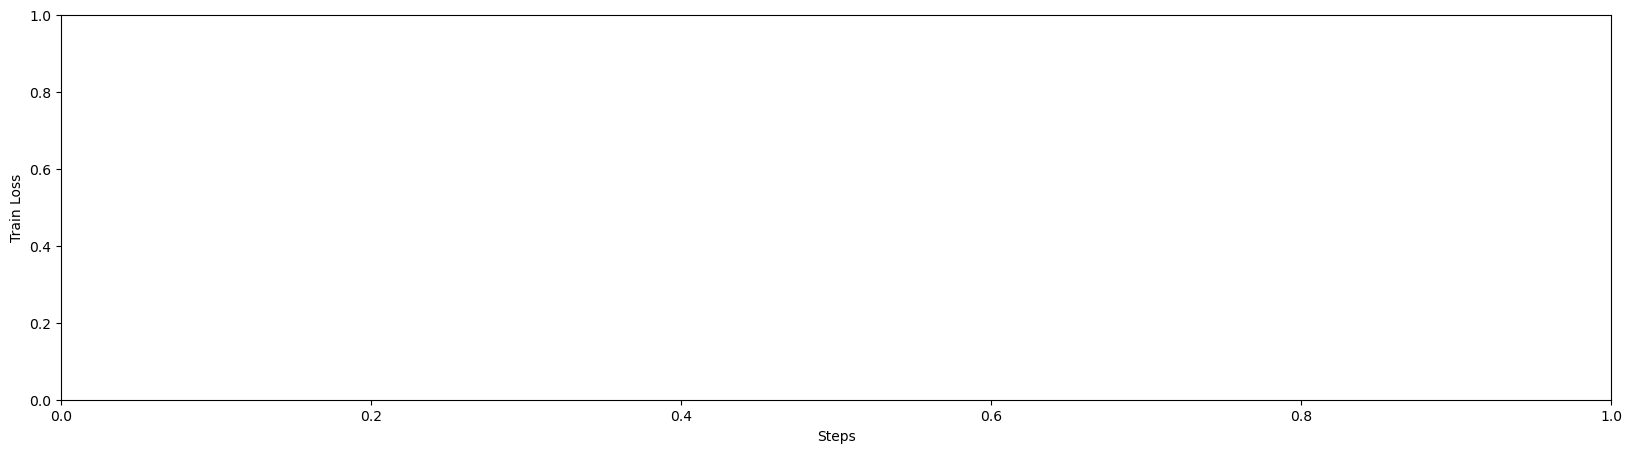

In [9]:
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = 20, 5

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()